_____________________________
**Groove Detection Project**
____________________________

Sara El Khbir sara.el_khbir@ens-paris-sacaly.fr

**Import necessary libraries**

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.models import load_model
from skimage.segmentation import find_boundaries
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import Model
from skimage.morphology import binary_closing
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.preprocessing import StandardScaler
from keras.losses import mean_squared_error, binary_crossentropy
from skimage.morphology import binary_erosion, binary_dilation, disk


c:\Users\User\anaconda3new\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
from utils import * 

**1-Data Exploration:**

In [4]:
#GET TRAIN DATA
images_folder = os.path.join('data_new/Train', 'images')
labels_folder = os.path.join('data_new/Train', 'labels')
train_images , train_labels = get_data(images_folder,labels_folder)
print(f"shape of train data is {np.shape(train_images)}")

Getting images from data_new/Train\images
Getting labels from data_new/Train\labels
Loading data done
shape of train data is (7211, 36, 36)


In [5]:
#GET VAL DATA
val_images_folder = os.path.join('data_new/Val', 'images')
val_labels_folder = os.path.join('data_new/Val', 'labels')
val_images , val_labels = get_data(val_images_folder,val_labels_folder)
print(f"shape of validation data is {np.shape(val_images)}")

Getting images from data_new/Val\images
Getting labels from data_new/Val\labels


Loading data done
shape of validation data is (2461, 36, 36)


In [6]:
#get test images
test_images_folder = os.path.join('data_new/Test','images')
test_images = get_test_images(test_images_folder)
print(f"shape of test images is {np.shape(test_images)} ")

Getting images from data_new/Test\images


Loading data done
shape of test images is (2538, 36, 36) 


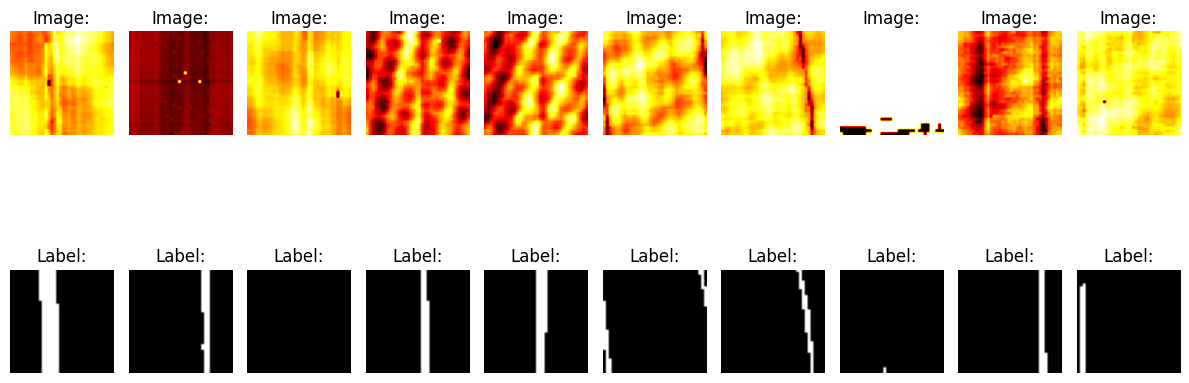

In [529]:

image_files = os.listdir(images_folder)

plt.figure(figsize=(12, 6))
for i in range(10):
    rand_index = np.random.randint(len(train_labels))
    image = train_images[rand_index]
    label = train_labels[rand_index]
    image_file = image_files[rand_index]
    plt.subplot(2, 10, i + 1)
    plt.imshow(image, cmap='hot')
    plt.title('Image:')
    plt.axis('off')
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(label, cmap='gray')
    plt.title('Label:')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
num_zero_images_train = count_zero_images(train_labels)
num_zero_images_val = count_zero_images(val_labels)
print("Number of labels that are  0 in train:", num_zero_images_train)
print("Number of labels that are  0 in val:", num_zero_images_val)


Number of labels that are  0 in train: 1720
Number of labels that are  0 in val: 278


***COMMENTAIRE:***
* The train data is composed of 7211 images with their corresponding labels (binary mask) , both of size (36,36). 1720 of these images have a label always = 0.
* The validation data is composed of 2461 images with their corresponding labels of which 278 have a 0 label.
The validation set contains two images with nan values that has been discarded from the data.
* The test set contains 2538 images with no labels.

* From the example images displayed , we can see that the goal is to segment the vertical/diagonal dark lines in the images corresponding to the grooves. The images with the label = 0 are most likely images of wells with no grooves.

**2- DEFINE THE MODEL:**

Here we define the UNet model:

**Encoder:**
- Consists of 4 convolutional layers with 32 ,32,64,64 filters respectively.
- The kernel size is of (3,3) in all layers.
- 2 Max pooling layers with a pool size of (2, 2)

**Bottleneck:**
Two convolutional layers with 128 filters (3,3) each.

**Decoder:**
Symmetric to the encoder.

The output is a segmentation map with a single channel (1), where each pixel represents the probability of belonging to the target class.

Total Parameters: 465953 (1.78 MB)



In [9]:
def unet(input_shape=(36, 36, 1), num_layers=2, kernel_size=(3, 3), num_filters=32):
    inputs = Input(input_shape)
    
    # Contracting Path
    conv_layers = []
    pool = inputs
    for _ in range(num_layers):
        conv = Conv2D(num_filters*(2**_), kernel_size, activation='relu', padding='same')(pool)
        conv = Conv2D(num_filters*(2**_), kernel_size, activation='relu', padding='same')(conv)
        conv_layers.append(conv)
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
    
    # Bottleneck
    conv = Conv2D(num_filters*(2**num_layers), kernel_size, activation='relu', padding='same')(pool)
    conv = Conv2D(num_filters*(2**num_layers), kernel_size, activation='relu', padding='same')(conv)
    
    # Expansive Path
    up = conv
    for i in range(num_layers):
        up = UpSampling2D(size=(2, 2))(up)
        up = Conv2D(num_filters*(2**(num_layers-1-i)), kernel_size, activation='relu', padding='same')(up)
        merge = concatenate([conv_layers[num_layers-1-i], up], axis=3)
        conv = Conv2D(num_filters*(2**(num_layers-1-i)), kernel_size, activation='relu', padding='same')(merge)
        conv = Conv2D(num_filters*(2**(num_layers-1-i)), kernel_size, activation='relu', padding='same')(conv)
    
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv)
    
    model = Model(inputs=[inputs], outputs=[output])
    return model

model = unet()
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 36, 36, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 36, 36, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 36, 36, 32)           9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 18, 18, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                         

**Define the loss and evaluation metrics**

### The Dice coefficient :
a similarity metric commonly used in image segmentation tasks. It measures the spatial overlap between two binary masks, typically the ground truth mask (y_true) and the predicted mask (y_pred).
$$ \text{Dice} = \frac{2 \times \text{Intersection} + \text{smooth}}{\text{Union} + \text{smooth}} $$
  where:
  - *Intersection* is the sum of overlapping pixels between *y_true* and *y_pred*.
  - *Union* is the sum of all pixels in both *y_true* and *y_pred*.
  - *smooth* is a small constant (usually 1) added to avoid division by zero.

 
### The Dice BCE loss :
that combines the Dice coefficient and Binary Cross-Entropy (BCE) loss into a single loss function. It optimize both the spatial overlap and pixel-wise classification accuracy simultaneously.

 $$\text{Dice BCE Loss} = \text{BCE Loss} + (1 - \text{Dice})$$
where:
  - *BCE Loss* is the Binary Cross-Entropy loss between *y_true* and *y_pred*.
  - *Dice* is the Dice coefficient calculated using the `dice_coefficient` function.



In [480]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_bce_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce_loss + dice_loss

In [400]:
#process the data for the input of the model
X_train, y_train = process_data_for_model(train_images,train_labels)
X_val, y_val = process_data_for_model(val_images,val_labels)

**Define the evaluation metrics**

* **Intersection over Union (IoU):** measures the overlap between the predicted segmentation mask and the ground truth mask.
It is calculated as the ratio of the area of intersection to the area of union between the two masks.
* **The Dice coefficient** defined above.
* **Pixel accuracy** : measures the percentage of correctly classified pixels in the segmentation task, computed as the ratio of the number of correctly classified pixels to the total number of pixels in the image.
* **Boundary F1 score:** evaluates the performance of the model based on its ability to delineate object boundaries accurately.
It calculates precision, recall, and F1 score specifically for the boundary pixels of the segmented objects.

In [98]:
custom_objects = {"dice_bce_loss": dice_bce_loss, "dice_coefficient": dice_coefficient}

In [534]:
# Define metrics functions
def intersection_over_union(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    iou = intersection / union
    return iou

def pixel_accuracy(y_true, y_pred):
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    accuracy = correct_pixels / total_pixels
    return accuracy

def dice_coefficient_metric(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2. * intersection) / (union + 1e-6)  # Adding epsilon to avoid division by zero
    return dice

def boundary_f1_score(y_true, y_pred):
    # Assuming y_true and y_pred are binary masks
    boundary_true = find_boundaries(y_true)
    boundary_pred = find_boundaries(y_pred)
    
    tp = np.sum(np.logical_and(boundary_true, boundary_pred))
    fp = np.sum(np.logical_and(np.logical_not(boundary_true), boundary_pred))
    fn = np.sum(np.logical_and(boundary_true, np.logical_not(boundary_pred)))
    
    precision = tp / (tp + fp + 1e-6) 
    recall = tp / (tp + fn + 1e-6)  
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)  
    return f1

**Tune the hyperparams**

In the TP5, I have somewhat tuned the hyperparams by hand rapidly but did not monitor the changes.

Here, I have launched several experiments and monitored the evolution of the loss and the dice_coefficient on `The validation data` through all of them.

1. **Batch Size :** The values 4, 16, 32, 128 has been tested
2. **Epochs:** Trained up to 50 epochs to see the evolution of the loss and dice coeff
3. **Loss function**  I tested the dice_bce_loss, mean_squared_error, binary_crossentropy losses

In [ ]:
# function to train the model
def train_model(X_train, y_train, X_val, y_val, batch_size, epochs,loss):
    model = unet()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss, metrics=[dice_coefficient])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    return model, history


> Batch Size:
We can clearly see from the plots that a batch size of 16 yields the best results with a loss decreasing up to 0.331 and with a Dice coeff= 0.787.

Training with batch size: 4
Epoch 1/20
1803/1803 [==============================] - 108s 57ms/step - loss: 0.9945 - dice_coefficient: 0.2564 - val_loss: 0.4154 - val_dice_coefficient: 0.6759
Epoch 2/20
1803/1803 [==============================] - 103s 57ms/step - loss: 0.5954 - dice_coefficient: 0.5563 - val_loss: 0.4170 - val_dice_coefficient: 0.7060
Epoch 3/20
1803/1803 [==============================] - 108s 60ms/step - loss: 0.5220 - dice_coefficient: 0.6139 - val_loss: 0.4241 - val_dice_coefficient: 0.7029
Epoch 4/20
1803/1803 [==============================] - 107s 59ms/step - loss: 0.4890 - dice_coefficient: 0.6388 - val_loss: 0.4244 - val_dice_coefficient: 0.7060
Epoch 5/20
1803/1803 [==============================] - 104s 58ms/step - loss: 0.4647 - dice_coefficient: 0.6567 - val_loss: 0.4127 - val_dice_coefficient: 0.7137
Epoch 6/20
1803/1803 [==============================] - 109s 60ms/step - loss: 0.4457 - dice_coefficient: 0.6713 - val_loss: 0.3768 - val_dice_coefficient: 0

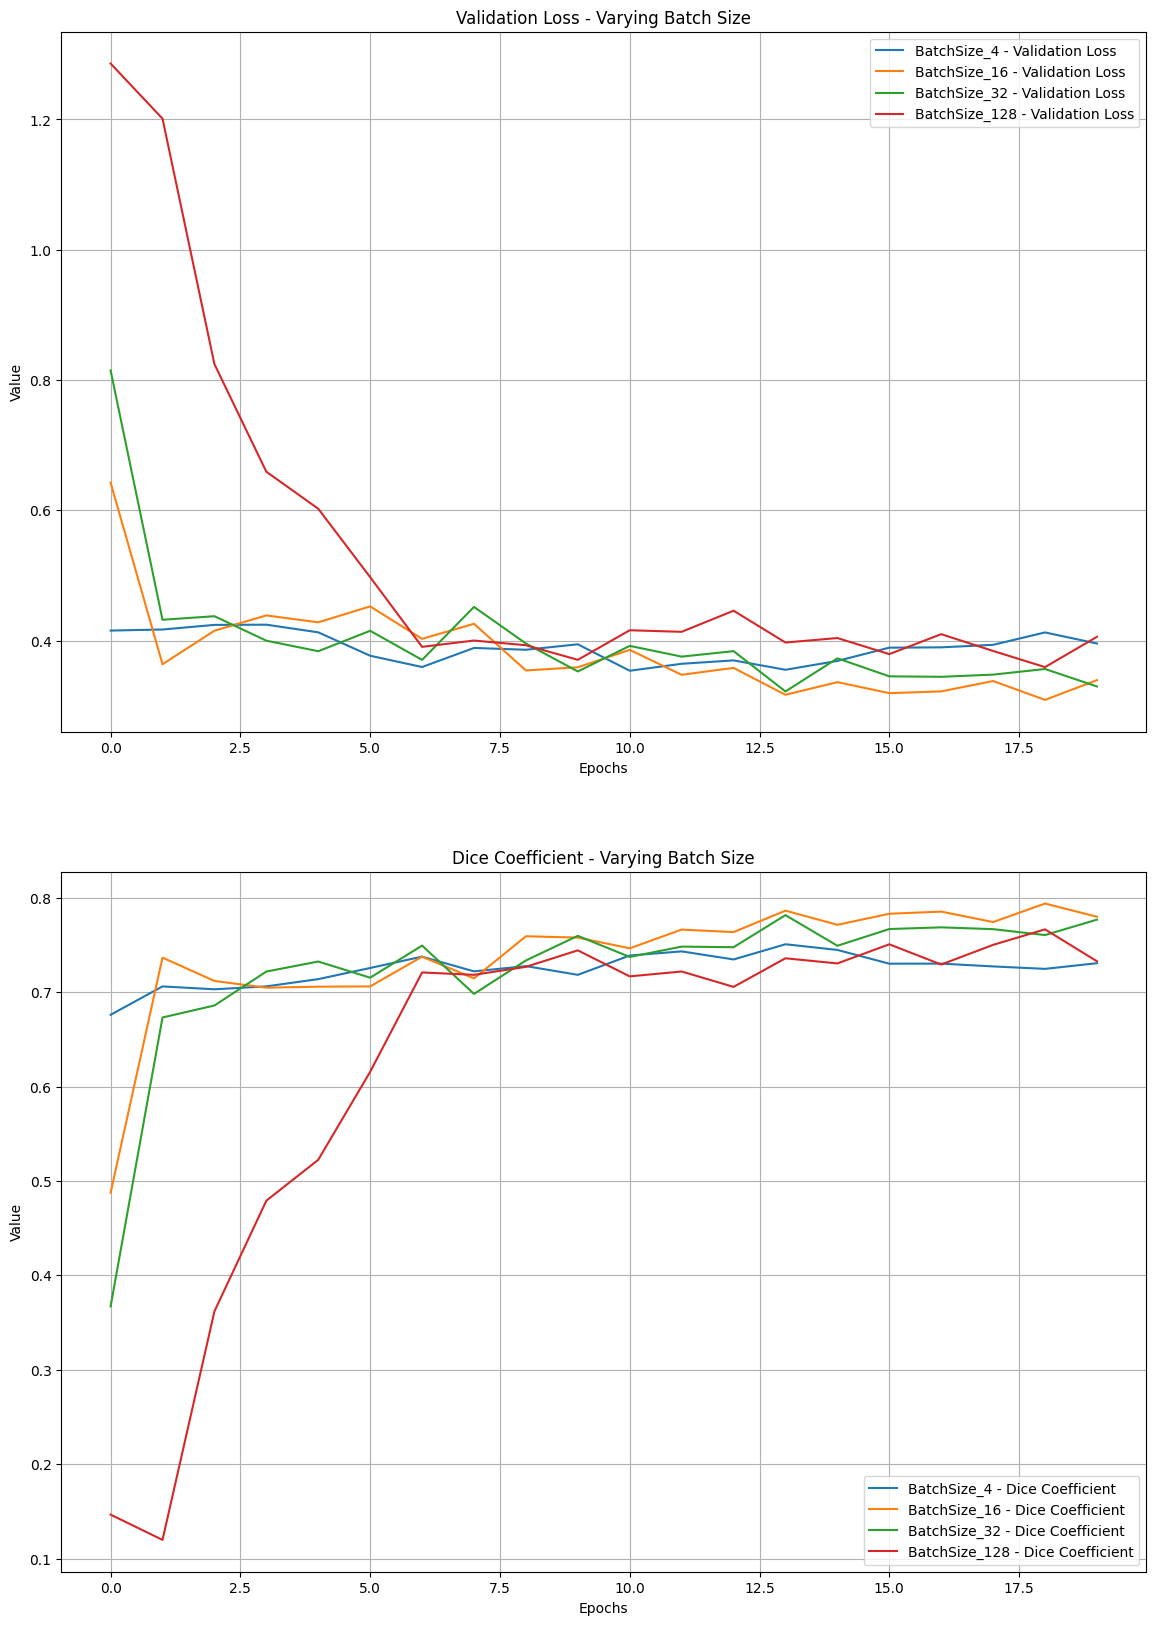

In [46]:

# Define lists to store results
batch_sizes = [4, 16, 32, 128]
epochs_list = [10, 20, 50]
loss_functions = [dice_bce_loss, mean_squared_error, binary_crossentropy]
histories = {}

# Run experiments for batch size
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    model, history = train_model(X_train, y_train, X_val, y_val, loss=dice_bce_loss, batch_size=batch_size, epochs=20)
    key = f"BatchSize_{batch_size}"
    histories[key] = history

# Plot results for batch size
fig, axs = plt.subplots(2, figsize=(14, 20))

for key, history in histories.items():
    axs[0].plot(history.history['val_loss'], label=f'{key} - Validation Loss')
    axs[1].plot(history.history['val_dice_coefficient'], label=f'{key} - Dice Coefficient')

axs[0].set_title('Validation Loss - Varying Batch Size')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Dice Coefficient - Varying Batch Size')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.show()

> Nb of epochs: From the plot below, we can see that best nb of epochs is around 20, which represents a minima for the loss a maxima for the dice coeff, the model tends to overfit the longer we train after 20 epochs

Training with epochs: 10
Epoch 1/10
451/451 [==============================] - 48s 101ms/step - loss: 1.1178 - dice_coefficient: 0.1763 - val_loss: 0.6456 - val_dice_coefficient: 0.4855
Epoch 2/10
451/451 [==============================] - 47s 105ms/step - loss: 0.6759 - dice_coefficient: 0.4913 - val_loss: 0.3463 - val_dice_coefficient: 0.7436
Epoch 3/10
451/451 [==============================] - 46s 101ms/step - loss: 0.5516 - dice_coefficient: 0.5946 - val_loss: 0.3598 - val_dice_coefficient: 0.7454
Epoch 4/10
451/451 [==============================] - 45s 101ms/step - loss: 0.5041 - dice_coefficient: 0.6312 - val_loss: 0.3810 - val_dice_coefficient: 0.7309
Epoch 5/10
451/451 [==============================] - 46s 102ms/step - loss: 0.4784 - dice_coefficient: 0.6495 - val_loss: 0.4116 - val_dice_coefficient: 0.7196
Epoch 6/10
451/451 [==============================] - 46s 101ms/step - loss: 0.4555 - dice_coefficient: 0.6671 - val_loss: 0.3823 - val_dice_coefficient: 0.7387
Epoch 7/1

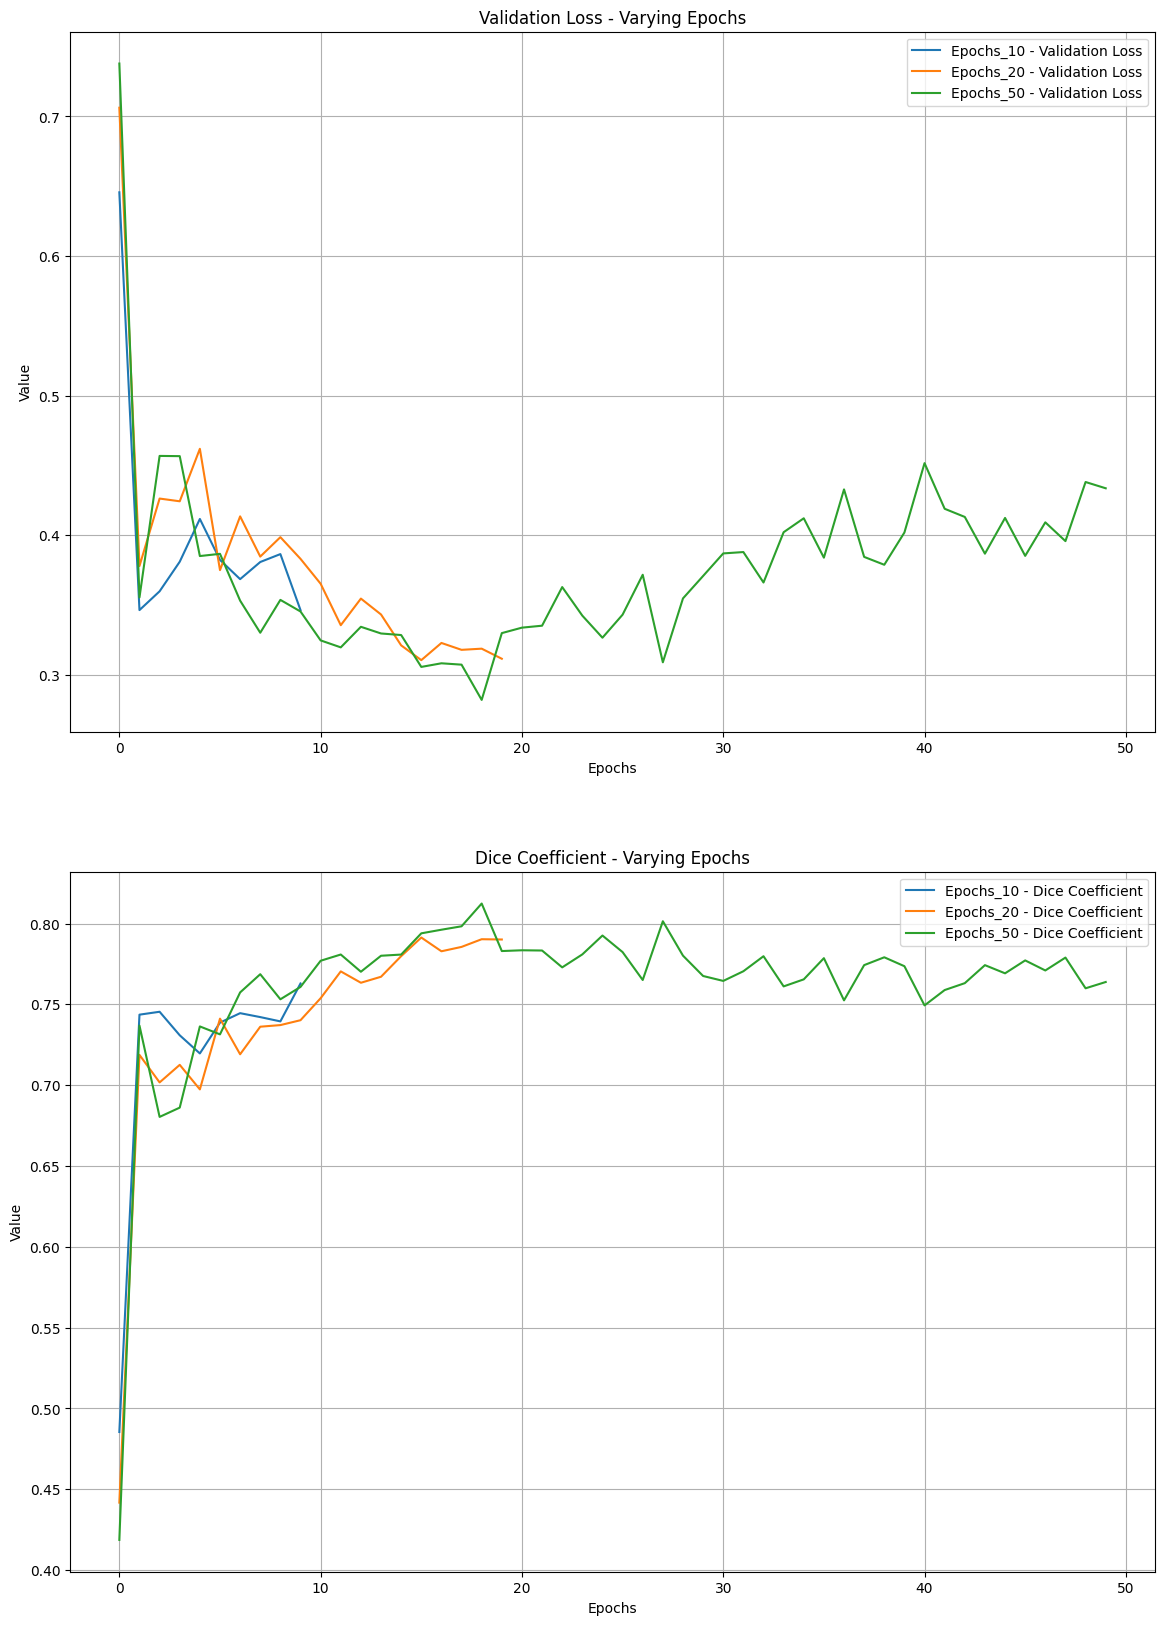

In [47]:
# Clear histories for epochs and loss functions
histories.clear()
for epochs in epochs_list:
    print(f"Training with epochs: {epochs}")
    model, history = train_model(X_train, y_train, X_val, y_val, loss=dice_bce_loss, batch_size=16, epochs=epochs)
    key = f"Epochs_{epochs}"
    histories[key] = history

# Plot results for epochs
fig, axs = plt.subplots(2, figsize=(14, 20))

for key, history in histories.items():
    axs[0].plot(history.history['val_loss'], label=f'{key} - Validation Loss')
    axs[1].plot(history.history['val_dice_coefficient'], label=f'{key} - Dice Coefficient')

axs[0].set_title('Validation Loss - Varying Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Dice Coefficient - Varying Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.show()

> Loss function: 
From the plots, we can see that the dice_bce_loss give better results (dice_coeff = 0.78) than MSE (0.74) and binary_cross_entropy ( 0.72). From the loss plot, we can see that the dice_bce_loss decreases only up to 0.3 while the others decrease to 0.1 and 0.03 .
In fact, the bce_dice_losss optimizes the combination of dice coefficient and binary cross-entropy, so it prioritizes accurate segmentation while penalizing misclassifications. The optimization process may stabilize at a higher loss value  due to the nature of the combined loss terms and the trade-offs involved, but yields better results.

Training with loss function: dice_bce_loss
Epoch 1/20
451/451 [==============================] - 45s 95ms/step - loss: 1.1381 - dice_coefficient: 0.1653 - val_loss: 0.6484 - val_dice_coefficient: 0.4813
Epoch 2/20
451/451 [==============================] - 45s 101ms/step - loss: 0.6941 - dice_coefficient: 0.4691 - val_loss: 0.4243 - val_dice_coefficient: 0.6955
Epoch 3/20
451/451 [==============================] - 46s 102ms/step - loss: 0.5574 - dice_coefficient: 0.5903 - val_loss: 0.3861 - val_dice_coefficient: 0.7266
Epoch 4/20
451/451 [==============================] - 44s 97ms/step - loss: 0.5068 - dice_coefficient: 0.6292 - val_loss: 0.3957 - val_dice_coefficient: 0.7259
Epoch 5/20
451/451 [==============================] - 44s 98ms/step - loss: 0.4821 - dice_coefficient: 0.6480 - val_loss: 0.4196 - val_dice_coefficient: 0.7174
Epoch 6/20
451/451 [==============================] - 44s 97ms/step - loss: 0.4637 - dice_coefficient: 0.6613 - val_loss: 0.3637 - val_dice_coefficient: 0.

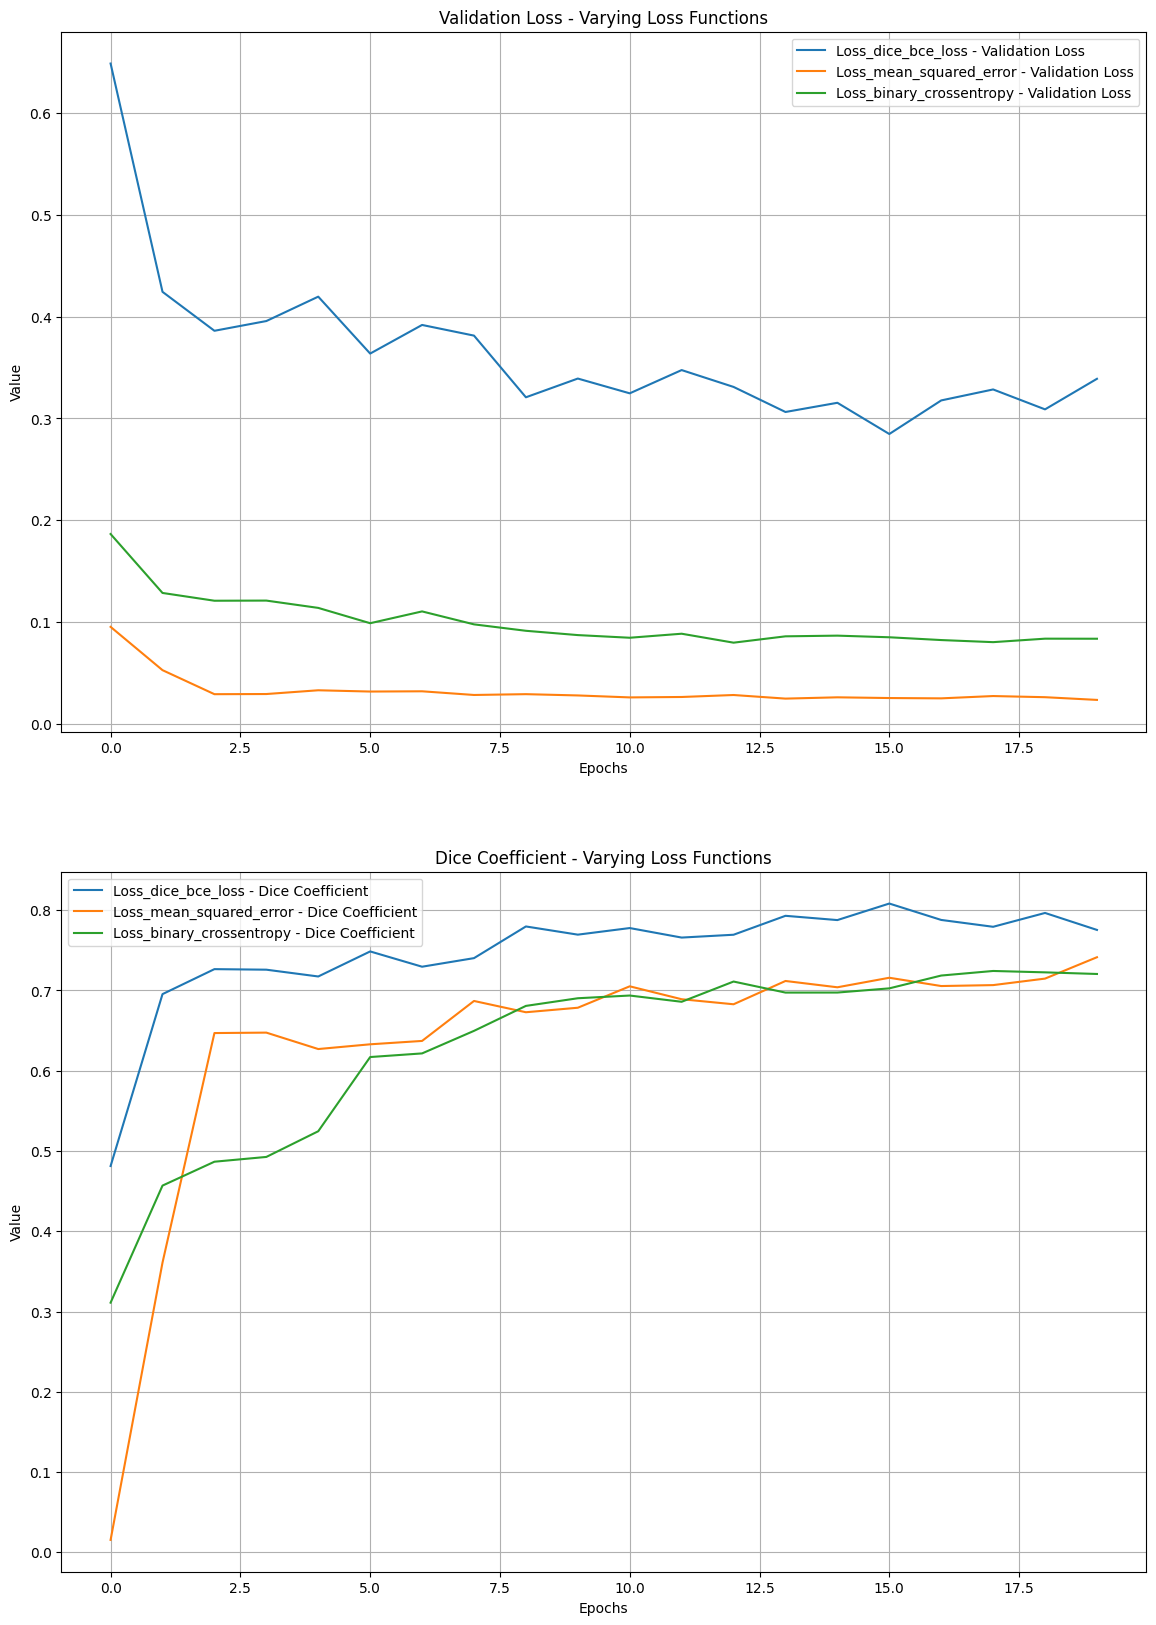

In [48]:
# Run experiments for loss functions
histories.clear()

for loss_func in loss_functions:
    print(f"Training with loss function: {loss_func.__name__}")
    model, history = train_model(X_train, y_train, X_val, y_val, loss=loss_func, batch_size=16, epochs=20)
    key = f"Loss_{loss_func.__name__}"
    histories[key] = history

# Plot results for loss functions
fig, axs = plt.subplots(2, figsize=(14, 20))
for key, history in histories.items():
    axs[0].plot(history.history['val_loss'], label=f'{key} - Validation Loss')
    axs[1].plot(history.history['val_dice_coefficient'], label=f'{key} - Dice Coefficient')

axs[0].set_title('Validation Loss - Varying Loss Functions')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Dice Coefficient - Varying Loss Functions')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)
plt.show()

>The hyperparam tuning gives the best model with the following results:

>| Loss | Dice coeff  |
>|------|------|
>|   0.331  | 0.782 |

>with the following params:
>`batch size = 16` , `nb_epochs = 20` , `loss_function =  dice_bce_loss`

**2-Augment data**

In this section, we apply:
1. **Preprocessing** , only with scaling the images before the training.
2. **Augmenting the data** with adding :
    - Horizontal Flipping of the images/labels
    - Horizontal shiffting of the images/labels
    
    No vertical operations has been done to the data due to the nature of the problem ( vertical grooves).

The new augmented dataset consists of 21633 images including the initial ones.

In [51]:
augmented_images, augmented_labels = augment_images(X_train, y_train, shift_range = 0.3)
print(np.shape(augmented_images))

(21633, 36, 36, 1)


> Examples of the augmented images

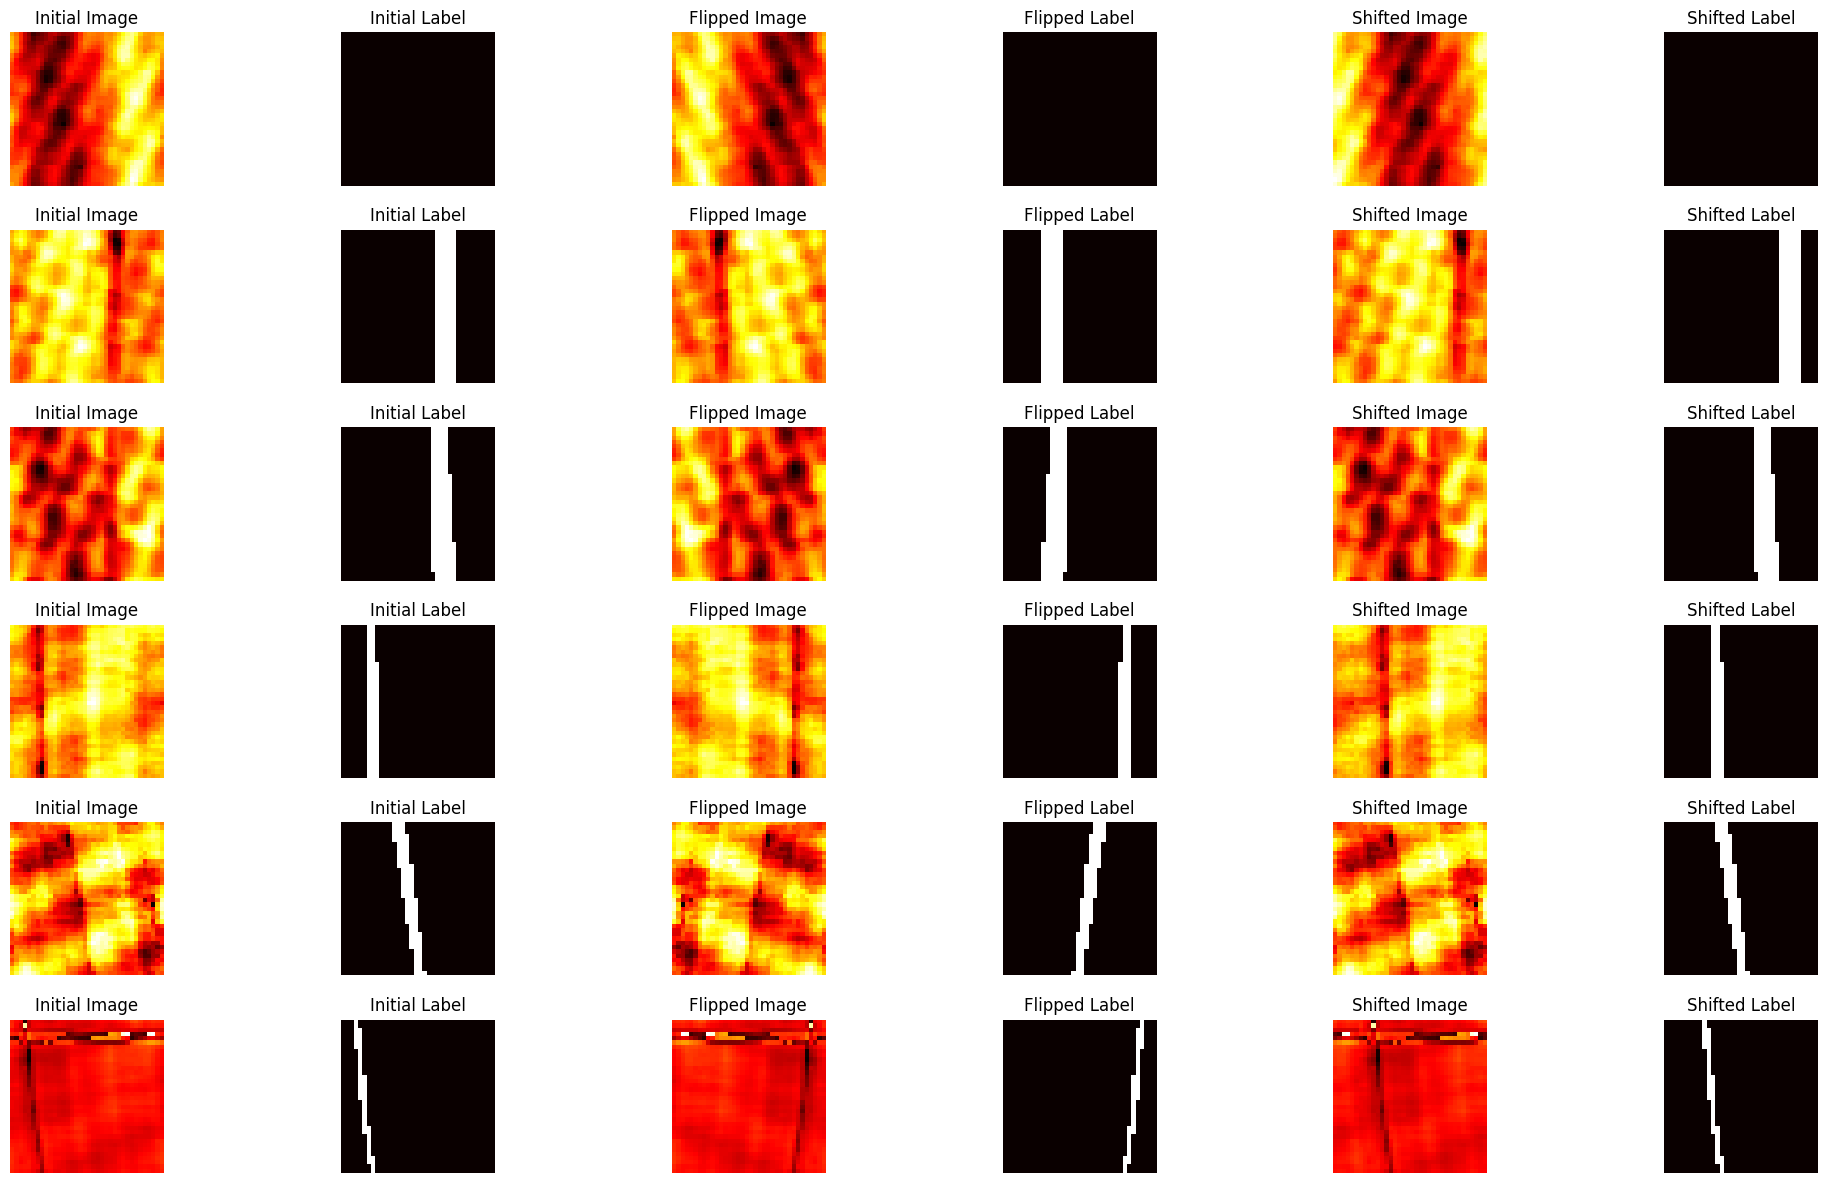

In [50]:
indices = np.random.choice(range(len(augmented_images) // 3), 6, replace=False) * 3

fig, axes = plt.subplots(len(indices), 6, figsize=(20, 2 * len(indices)))
fig.tight_layout()

for i, idx in enumerate(indices):
    initial_idx = idx
    flipped_idx = idx + 1
    shifted_idx = idx + 2
    axes[i, 0].imshow(augmented_images[initial_idx], 'hot')
    axes[i, 0].set_title('Initial Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(augmented_labels[initial_idx], 'hot')
    axes[i, 1].set_title('Initial Label')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(augmented_images[flipped_idx], 'hot')
    axes[i, 2].set_title('Flipped Image')
    axes[i, 2].axis('off')
    axes[i, 3].imshow(augmented_labels[flipped_idx], 'hot')
    axes[i, 3].set_title('Flipped Label')
    axes[i, 3].axis('off')
    axes[i, 4].imshow(augmented_images[shifted_idx], 'hot')
    axes[i, 4].set_title('Shifted Image')
    axes[i, 4].axis('off')
    axes[i, 5].imshow(augmented_labels[shifted_idx], 'hot')
    axes[i, 5].set_title('Shifted Label')
    axes[i, 5].axis('off')
plt.show()

> Here we do three experiments, one training with the initial datasets, one with the preprocessed data then with the augmented data , and we monitor the results on the validation set.


Training with original data
Epoch 1/20
451/451 [==============================] - 54s 115ms/step - loss: 1.1292 - dice_coefficient: 0.1684 - val_loss: 0.6946 - val_dice_coefficient: 0.4483
Epoch 2/20
451/451 [==============================] - 51s 113ms/step - loss: 0.7308 - dice_coefficient: 0.4383 - val_loss: 0.3601 - val_dice_coefficient: 0.7321
Epoch 3/20
451/451 [==============================] - 56s 123ms/step - loss: 0.5733 - dice_coefficient: 0.5754 - val_loss: 0.3942 - val_dice_coefficient: 0.7126
Epoch 4/20
451/451 [==============================] - 55s 122ms/step - loss: 0.5163 - dice_coefficient: 0.6212 - val_loss: 0.3774 - val_dice_coefficient: 0.7419
Epoch 5/20
451/451 [==============================] - 56s 124ms/step - loss: 0.4869 - dice_coefficient: 0.6437 - val_loss: 0.3733 - val_dice_coefficient: 0.7441
Epoch 6/20
451/451 [==============================] - 56s 125ms/step - loss: 0.4637 - dice_coefficient: 0.6608 - val_loss: 0.3553 - val_dice_coefficient: 0.7505
Epoch 

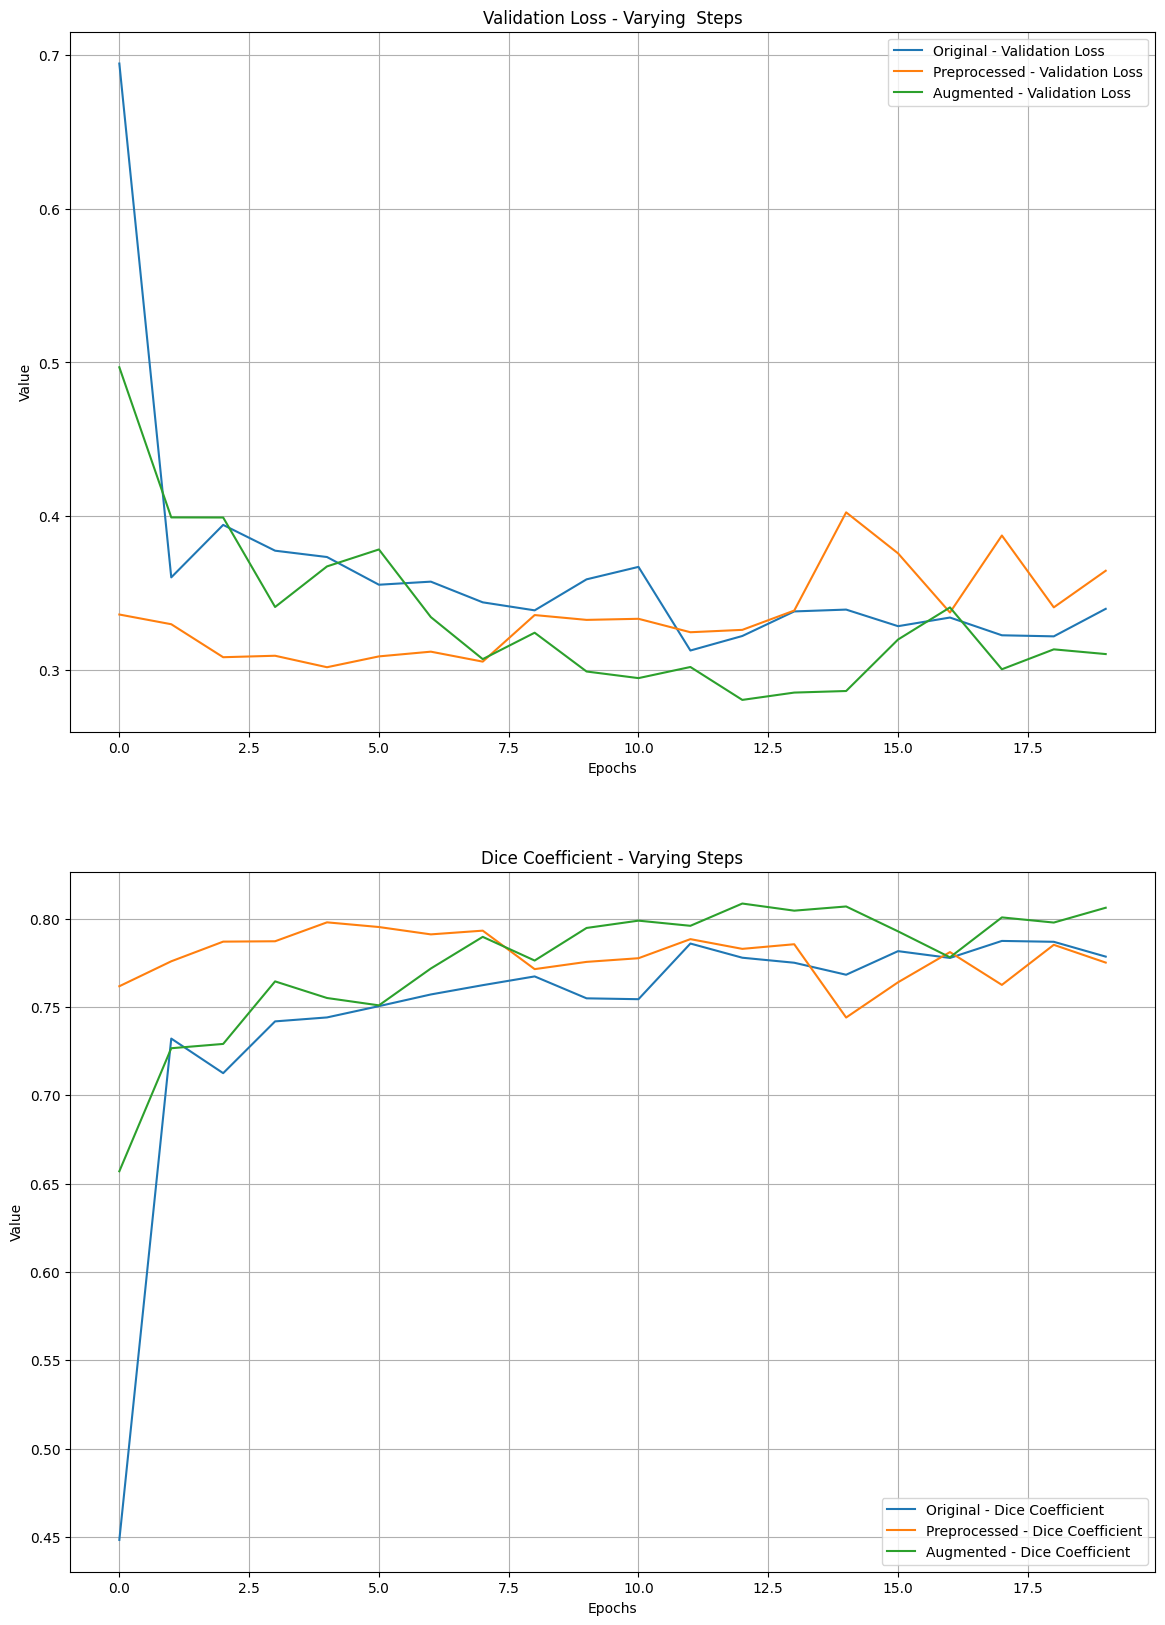

In [77]:
# Define lists to store results
preprocessing_steps = ['Original', 'Preprocessed', 'Augmented']
histories = {}

# Define your model and compile it

for step in preprocessing_steps:
    if step == 'Original':
        X_train_processed, X_val_processed = X_train, X_val
        y_train_processed, y_val_processed = y_train, y_val

    elif step == 'Preprocessed':
        X_train_processed = preprocess_images(X_train)
        X_val_processed = preprocess_images(X_val)
        y_train_processed, y_val_processed = y_train, y_val

    elif step == 'Augmented':
        X_train_processed, y_train_processed = augment_images(X_train, y_train, shift_range = 0.3)
        X_val_processed, y_val_processed = X_val, y_val 


    print(f"Training with {step.lower()} data")
    model, history = train_model(X_train_processed, y_train_processed, X_val_processed, y_val_processed, loss = dice_bce_loss, batch_size=16, epochs=20)
    histories[step] = history


fig, axs = plt.subplots(2, figsize=(14, 20))

for step, history in histories.items():
    axs[0].plot(history.history['val_loss'], label=f'{step} - Validation Loss')
    axs[1].plot(history.history['val_dice_coefficient'], label=f'{step} - Dice Coefficient')
axs[0].set_title('Validation Loss - Varying  Steps')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)
axs[1].set_title('Dice Coefficient - Varying Steps')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)
plt.show()

> The dice coefficient of 
>| Initial | Preprocessed  | Augmented |
>|------|------|------|
>|   0.785  | 0.782 | 0.813 |

The preprocessing didn't really affect the training. The Dice coefficient with the augmented data is of `0.813` which means that data augmentation has had a positive impact on the segmentation accuracy. The augmented data may have provided more diverse training examples, allowing the model to learn more robust features and improve its segmentation performance.

**Evaluating and infering the best model**

In [530]:
#Load the best model
model = load_model('augmented_model.h5',custom_objects=custom_objects)

In [551]:
# Calculate metrics for the val set
iou_scores = []
dice_scores = []
pixel_accs = []
boundary_f1_scores = []
num_non_empty_masks =0
for i in range(len(val_images)):
    image = val_images[i]
    ground_truth_label = val_images[i]
    predicted_mask = predict_image(model, image)
# Check if both ground truth and predicted mask are non-empty
    if np.any(ground_truth_label) or np.any(predicted_mask):
        # Calculate metrics
        iou_scores.append(intersection_over_union(ground_truth_label, predicted_mask))
        pixel_accs.append(pixel_accuracy(ground_truth_label, predicted_mask))
        dice_scores.append(dice_coefficient_metric(ground_truth_label, predicted_mask))
        boundary_f1_scores.append(boundary_f1_score(ground_truth_label, predicted_mask))
        num_non_empty_masks += 1

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step


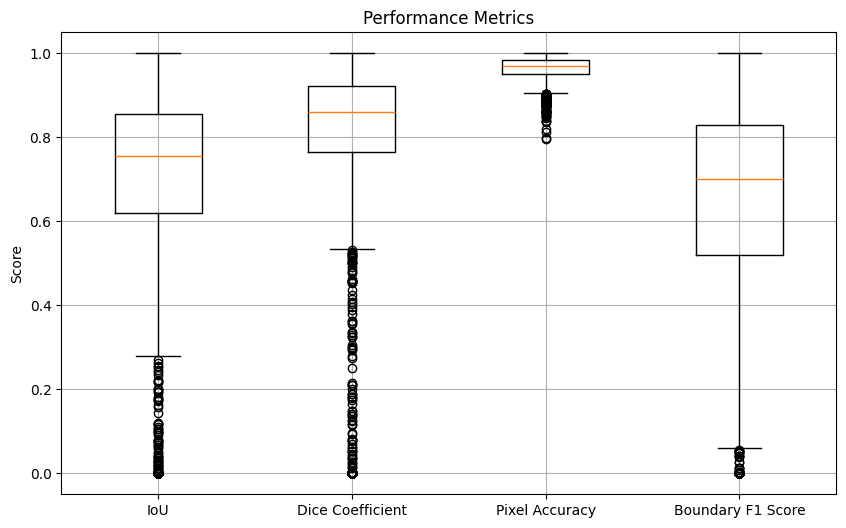

In [537]:
#boxplot of the metrics
metric_names = ['IoU', 'Dice Coefficient', 'Pixel Accuracy', 'Boundary F1 Score']
metric_scores = [iou_scores, dice_scores, pixel_accs, boundary_f1_scores]

# Plot boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(metric_scores, labels=metric_names)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.grid(True)
plt.show()

> - IoU : For the IoU,we have over the validatio data, a range of values between 0.3 and 1 with the IQR being between 0.61 >and 0.83 and a median of 0.78, this shows that  a significant portion of the validation data has good segmentation >overlap, but there are also cases with lower IoU values that may need improvement.
>- Dice coefficient : The IQR range for the the dice coeff is between 0.78 and 0.9 with a median of 0.82.
>- The pixel accuracy is concentrated close to one with a median of 0.96. The pixel accuracy is high because the images >without grooves are redundant and so their labels are void making the accuracy get very high.
>-The boundary F1 Score is mainly between 0.52 and 0.81 with a medain of 0.7. This explains the grooves we will see later, >that the model detects and which boundary isn't always consistent to that of the annotation.

**Examples of the validation data**

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


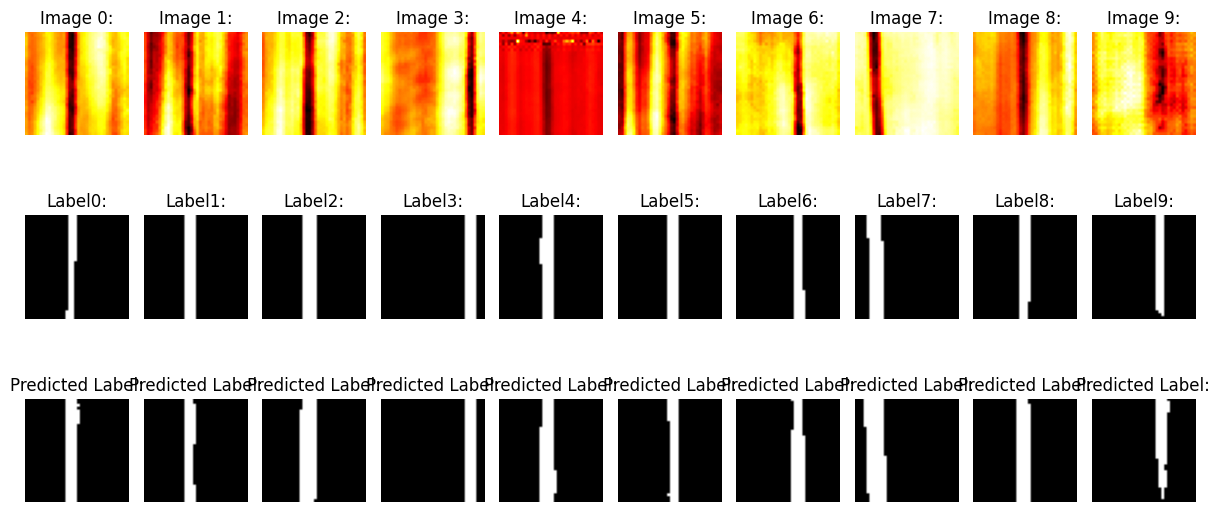

In [543]:
plt.figure(figsize=(12, 6))
for i in range(10):
    rand_index = np.random.randint(len(val_images))
    image = val_images[rand_index]
    label = val_labels[rand_index]
    predicted_mask = predict_image(model, image)
    plt.subplot(3, 10, i + 1)
    plt.imshow(image, cmap='hot')
    plt.title(f'Image {i}:')
    plt.axis('off')
    plt.subplot(3, 10, 10 + i + 1)
    plt.imshow(label, cmap='gray')
    plt.title(f'Label{i}:')
    plt.axis('off')
    plt.subplot(3,10,20+i+1)
    plt.imshow(predicted_mask, cmap = 'gray')
    plt.title('Predicted Label:')
    plt.axis('off')
plt.tight_layout()
plt.show()

>We can see from these images, that the networks detects well the existant of grooves in the images, it is just that the >segmentation is not 100% consistent with the ground truth which increases the number of false positive /  false negative >pixels.

> **INFERENCE ON THE TEST SET**

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 100ms/step


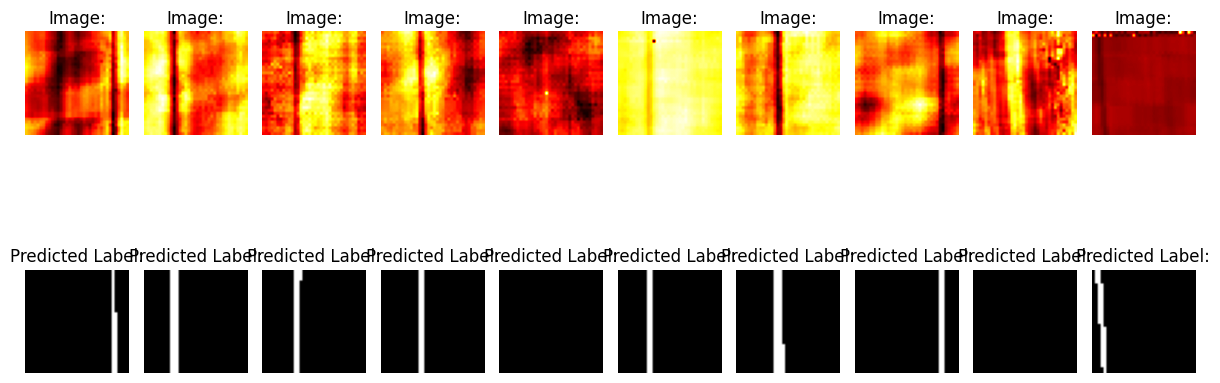

In [550]:
plt.figure(figsize=(12, 6))
for i in range(10):
    rand_index = np.random.randint(len(test_images))
    image = test_images[rand_index]
    predicted_mask = predict_image(model, image)
    plt.subplot(2, 10, i + 1)
    plt.imshow(image, cmap='hot')
    plt.title('Image:')
    plt.axis('off')
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Label:')
    plt.axis('off')
plt.tight_layout()
plt.show()

>Here, we don't have the ground truth labels to compare our results to, but we can see that indeed the segmented parts >correspond to the parts of the images that have the grooves ( vertical/diagonal lines).

**Knowledge Distillation**

 >Implementing knowledge distillation involves training a smaller model (student) to mimic the predictions of a larger 
>Knowledge distillation is a technique used to transfer knowledge from a large, complex model (teacher) to a smaller, >simpler model (student). 
>To do this, we will follow theses steps:
>1. Train the teacher model ( the one that yields the best results. `Dice = 0.81`). This teacher model will provide soft >targets for the knowledge distillation process.
>
>2. During training, instead of using hard targets (the actual labels),we will use the soft targets generated by the >teacher model.
>
>3. Tune the temperature parameter, which scales the logits before applying softmax. This parameter controls the softness >of the targets.

In [316]:
teacher_model = load_model("augmented_model.h5", custom_objects=custom_objects)

train_predictions = teacher_model.predict(X_train)
val_predictions = teacher_model.predict(X_val)
# Apply the inverse sigmoid activation
train_predictions_no_logits = inverse_sigmoid(train_predictions)
val_predictions_no_logits = inverse_sigmoid(val_predictions)

77/77 [==============================] - 5s 67ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_7720\2163394229.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.log(x / (1 - x))
C:\Users\User\AppData\Local\Temp\ipykernel_7720\2163394229.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x / (1 - x))


>In knowledge distillation, the temperature coefficient controls the softness of the targets produced by the teacher model >before they are used to train the student model.
>In the following, we will observe how the confidence levels of predictions change as the temperature varies. (For one image). As there are significant changes in confidence levels across temperature values, it indicates that temperature scaling is indeed affecting the model's output confidence.



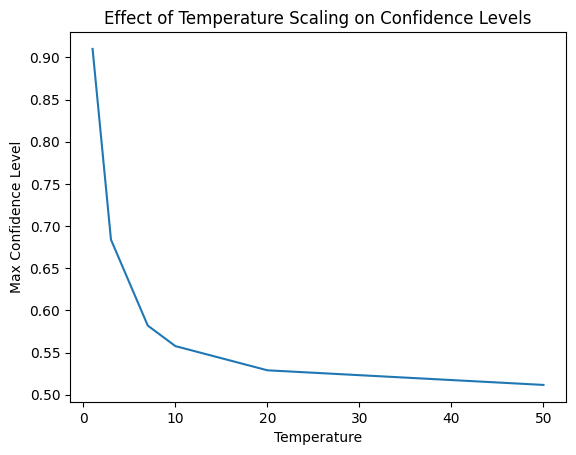

In [310]:
x = train_predictions_no_logits[122]
temperature = [1,3,7,10,20,50]
# Calculate softmax output for each temperature
softmax_outputs = [sigmoid(x / temp) for temp in temperature]
# Calculate confidence levels (maximum softmax probability) for each temperature
confidence_levels = [np.max(softmax_output) for softmax_output in softmax_outputs]
plt.plot(temperature, confidence_levels)
plt.xlabel('Temperature')
plt.ylabel('Max Confidence Level')
plt.title('Effect of Temperature Scaling on Confidence Levels')
plt.show()

>The teacher model has a size of  `1.55 MB`

>Next we will create 4 small models:
>    - one_layer_unet with 1 convolutional block instead of 2. ( Size = 434.38kB)
>    - a unet with 2 conv blocks but with `16 filters` (Size = 397.82 kB)
>    - a unet with 2 conv blocks but with `8 filters` (Size = 99.91 kB)
>    - a unet with 1 conv blocks but with `8 filters` (Size = 27.6 kB)

>Then we will test 3 temperature valuess `1,2,5`


In [553]:
one_layer_unet = unet(num_layers=1)
unet_16_filt = unet(num_filters=16)
unet_8_filt = unet(num_filters=8)
one_layer_unet_8filt = unet(num_layers=1, num_filters=8)

model.summary()
one_layer_unet.summary()
unet_16_filt.summary()
unet_8_filt.summary()
one_layer_unet_8filt.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 36, 36, 1)]          0         []                            
                                                                                                  
 conv2d_130 (Conv2D)         (None, 36, 36, 32)           320       ['input_11[0][0]']            
                                                                                                  
 conv2d_131 (Conv2D)         (None, 36, 36, 32)           9248      ['conv2d_130[0][0]']          
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 18, 18, 32)           0         ['conv2d_131[0][0]']          
 ng2D)                                                                                     

In [330]:
def train_model_with_distillation(student_model, X_train, X_val, y_val,
                                  train_predictions_no_logits,val_predictions_no_logits, temperature, batch_size, epochs):
# Perform a manual softmax at raised temperature
    Y_train_soft = sigmoid(train_predictions_no_logits/temperature)
    Y_test_soft = sigmoid(val_predictions_no_logits / temperature )
    student_model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_bce_loss, metrics=[dice_coefficient])
# Train the student model
    history = student_model.fit(X_train, Y_train_soft,
                  batch_size=batch_size,  # Adjust batch size as needed
                  epochs=epochs,
                  validation_data=(X_val,  Y_test_soft))
    loss, dice = student_model.evaluate(X_val, y_val)
    print("Validation Loss:", loss)
    print("Validation Dice Coefficient:", dice)
    return student_model, history, loss ,dice

In [332]:
save_dir = 'saved_small_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
X_train_processed, y_train_processed = augment_images(X_train, y_train, shift_range = 0.3)

temperatures = [1,2,5]  # Tune temperature parameter for each student model
student_models = []
validation_dice_coefficients = []
student_histories = {}

for model in [one_layer_unet, unet_16_filt, unet_8_filt, one_layer_unet_8filt]:
    for temp in temperatures:
        print(f"Training {model.name} with temperature {temp}")
        student_model, history ,loss, dice = train_model_with_distillation(model, X_train, X_val, y_val,
                                                               train_predictions_no_logits, val_predictions_no_logits,
                                                               temp, batch_size=16, epochs=20)
        student_models.append(student_model)
        validation_dice_coefficients.append(dice)
        
        key = f"Model_{str(model.name)}_Temp_{temp}"
        student_histories[key] = history  # Now history contains dice coefficient info

        # Save the trained student model
        model_filename = f"{model.name}_Temp_{temp}.h5"
        model_path = os.path.join(save_dir, model_filename)
        student_model.save(model_path)
        print(f"Saved model at {model_path}")




Training model_91 with temperature 1
Epoch 1/20
451/451 [==============================] - 39s 83ms/step - loss: 1.1272 - dice_coefficient: 0.1694 - val_loss: 0.6927 - val_dice_coefficient: 0.4750
Epoch 2/20
451/451 [==============================] - 36s 80ms/step - loss: 0.7032 - dice_coefficient: 0.4604 - val_loss: 0.4397 - val_dice_coefficient: 0.7127
Epoch 3/20
451/451 [==============================] - 36s 80ms/step - loss: 0.5916 - dice_coefficient: 0.5563 - val_loss: 0.4110 - val_dice_coefficient: 0.7448
Epoch 4/20
451/451 [==============================] - 36s 80ms/step - loss: 0.5357 - dice_coefficient: 0.5991 - val_loss: 0.4570 - val_dice_coefficient: 0.7176
Epoch 5/20
451/451 [==============================] - 36s 79ms/step - loss: 0.5008 - dice_coefficient: 0.6245 - val_loss: 0.4464 - val_dice_coefficient: 0.7290
Epoch 6/20
451/451 [==============================] - 36s 80ms/step - loss: 0.4717 - dice_coefficient: 0.6478 - val_loss: 0.4384 - val_dice_coefficient: 0.7354
Epo

c:\Users\User\anaconda3new\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/20
451/451 [==============================] - 38s 80ms/step - loss: 0.4726 - dice_coefficient: 0.6654 - val_loss: 0.4702 - val_dice_coefficient: 0.7151
Epoch 2/20
451/451 [==============================] - 37s 83ms/step - loss: 0.4668 - dice_coefficient: 0.6670 - val_loss: 0.4708 - val_dice_coefficient: 0.7186
Epoch 3/20
451/451 [==============================] - 38s 83ms/step - loss: 0.4627 - dice_coefficient: 0.6697 - val_loss: 0.4799 - val_dice_coefficient: 0.7152
Epoch 4/20
451/451 [==============================] - 40s 89ms/step - loss: 0.4580 - dice_coefficient: 0.6731 - val_loss: 0.4666 - val_dice_coefficient: 0.7219
Epoch 5/20
451/451 [==============================] - 38s 85ms/step - loss: 0.4554 - dice_coefficient: 0.6749 - val_loss: 0.4474 - val_dice_coefficient: 0.7275
Epoch 6/20
451/451 [==============================] - 38s 85ms/step - loss: 0.4519 - dice_coefficient: 0.6775 - val_loss: 0.4488 - val_dice_coefficient: 0.7266
Epoch 7/20
451/451 [====================

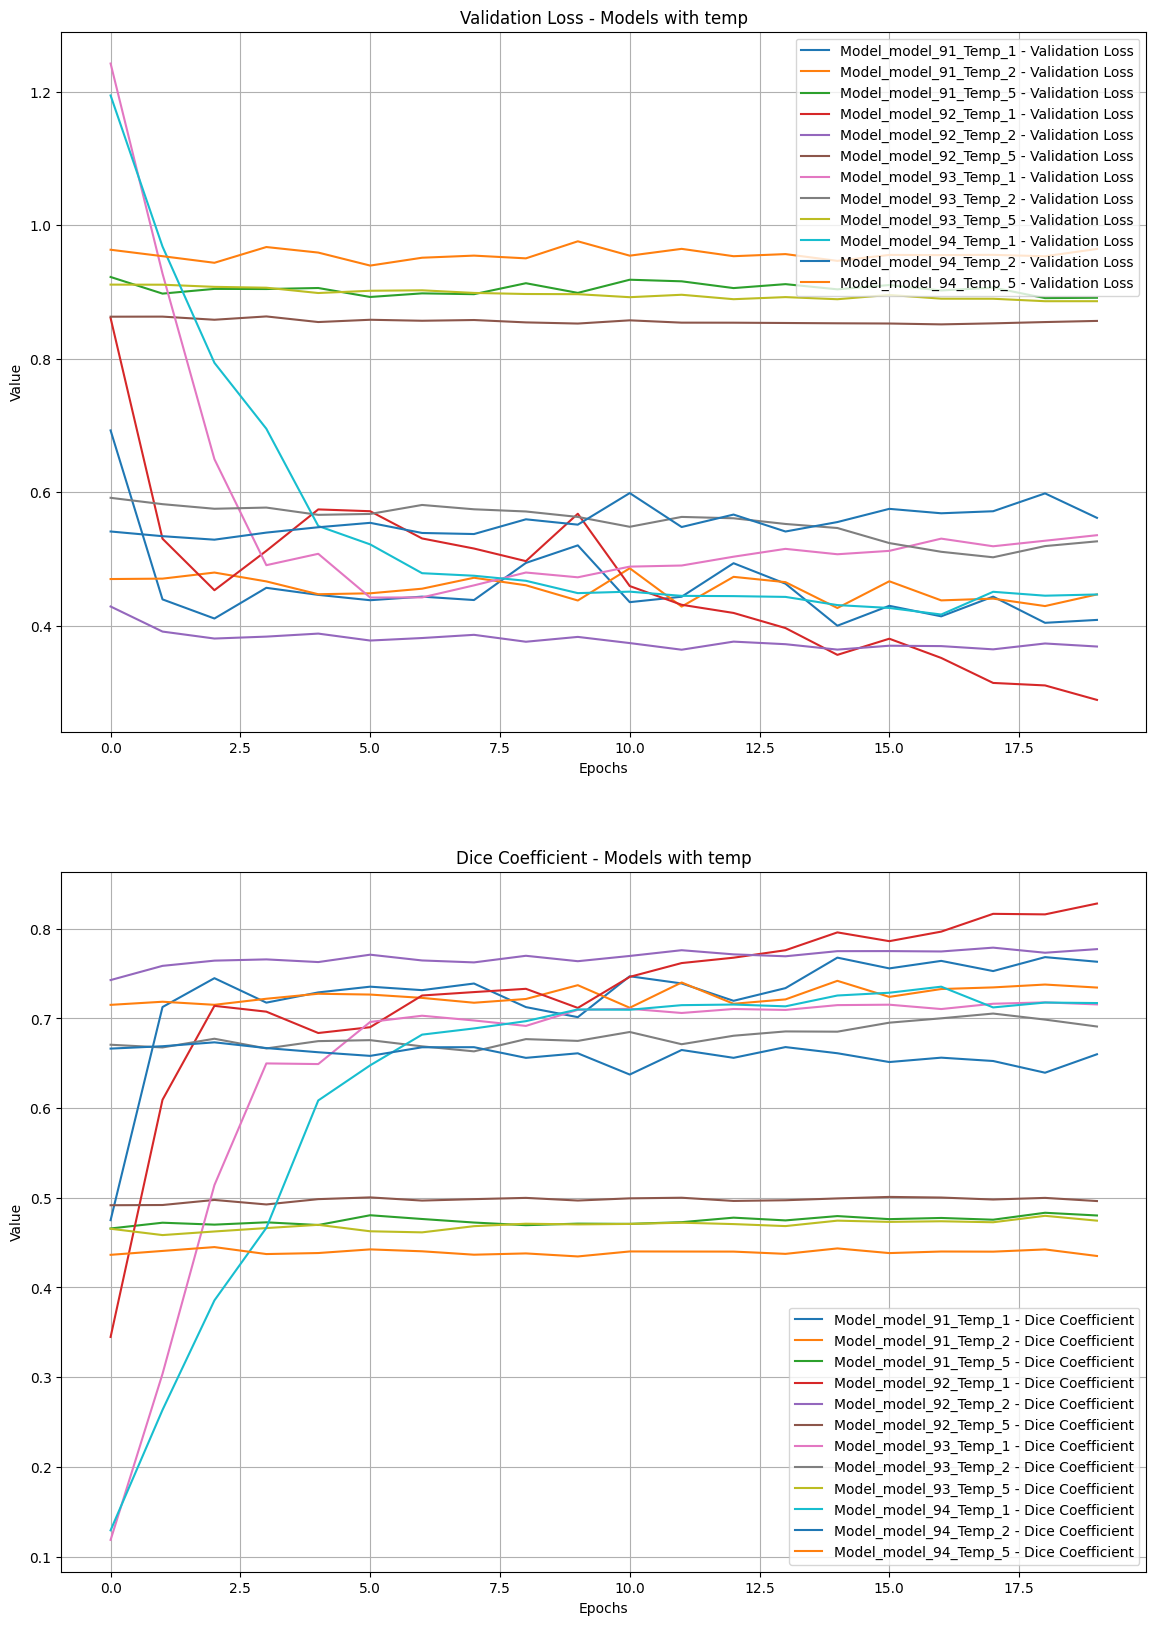

In [333]:
# Plot results for batch size
fig, axs = plt.subplots(2, figsize=(14, 20))

for key, history in student_histories.items():
    axs[0].plot(history.history['val_loss'], label=f'{key} - Validation Loss')
    axs[1].plot(history.history['val_dice_coefficient'], label=f'{key} - Dice Coefficient')

axs[0].set_title('Validation Loss - Models with temp')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Dice Coefficient - Models with temp')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.show()

>From the plots, we can see that:
>All the models with temperature = 5 don't seem to learn anything. 
>The temperature 1 and 2 yield approximately the same results.
>The small model that yields results equal to those of the teacher model is the unet with 16 filters (Dice coeff = 0.81).
>The very small model ( with 1 conv block and only 8 filters) performs the poorest with the best dice_coeff at 0.74


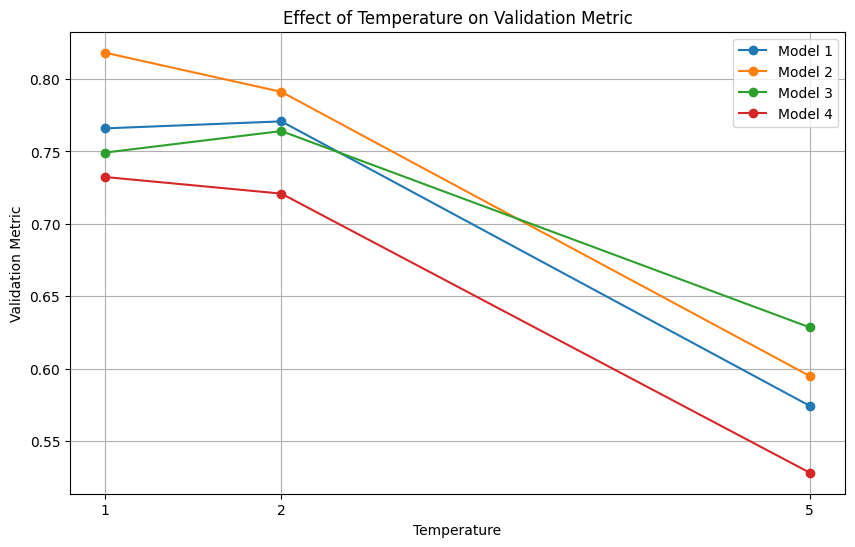

In [569]:
temps = [1, 2, 5]
validation_metrics = [
    [0.76596599817276, 0.7708061933517456, 0.574222981929779],
    [0.8182332515716553, 0.791183352470398, 0.5948419570922852],
    [0.7492615580558777, 0.764106273651123, 0.6284656524658203],
    [0.7323441505432129, 0.7208852171897888, 0.5280487537384033]
]

plt.figure(figsize=(10, 6))
for i, metric in enumerate(validation_metrics):
    plt.plot(temps, metric, marker='o', label=f'Model {i+1}')

plt.xlabel('Temperature')
plt.ylabel('Validation Metric')
plt.title('Effect of Temperature on Validation Metric')
plt.legend()
plt.grid(True)
plt.xticks(temps)
plt.show()

>Higher temperatures lead to softer targets, emphasizing relative probabilities rather than hard decisions.
>In fact when the temp is too high, the soft targets become very soft, almost uniform which lead to loss of information as the relative differences in probabilities become less pronounced so the small model may end up learning less discriminative features and might struggle to capture the intricate details present in the data.

>We keep the student model with 2 conv blocks and 16 filters as with this model we keep the same results but compress the model from `1.55Mb` to `397.82kB`

**QUANTIZATION**

In this last part, we will quantizing the knowledge distillation model to reduce its precision from float32 to int16 and int8.  This quantization process aims to reduce the memory footprint and computational cost of the KD model while maintaining an acceptable level of accuracy.

In [565]:
# Load the KD model obtained from knowledge distillation
kd_model = load_model("saved_small_models/model_92_Temp_1.h5",custom_objects=custom_objects)

# Convert the model to use int16 weights
quant16_model = tf.keras.models.clone_model(kd_model)
quant16_model.set_weights([np.round(w * 2**15) / 2**15 for w in kd_model.get_weights()])
kd_model = load_model("saved_small_models/model_92_Temp_1.h5",custom_objects=custom_objects)
# Convert the model to use int8 weights
quant8_model = tf.keras.models.clone_model(kd_model)
quant8_model.set_weights([np.round(w * 2**7) / 2**7 for w in kd_model.get_weights()])


In [566]:
_, dice_kd = kd_model.evaluate(X_val,y_val)
quant16_model.compile(loss=dice_bce_loss,metrics=[dice_coefficient])
_,dice16 = quant16_model.evaluate(X_val,y_val)
quant8_model.compile(loss=dice_bce_loss,metrics=[dice_coefficient])
_,dice_ = quant8_model.evaluate(X_val,y_val)

34/77 [============>.................] - ETA: 0s - loss: 0.2597 - dice_coefficient: 0.8456

77/77 [==============================] - 2s 18ms/step - loss: 0.2812 - dice_coefficient: 0.8332


In [567]:
_, dice_kd = kd_model.evaluate(X_val,y_val)
quant16_model.compile(loss=dice_bce_loss,metrics=[dice_coefficient])
_,dice16 = quant16_model.evaluate(X_val,y_val)


77/77 [==============================] - 2s 16ms/step - loss: 0.2812 - dice_coefficient: 0.8332


In [516]:
# Measure size decrease compared to the original model
quant16_model.save("quant16_model.h5")
quant8_model.save("quant8_model.h5")

# Measure size decrease compared to the original model
original_size = os.path.getsize("saved_small_models/model_92_Temp_1.h5")
quant16_size = os.path.getsize("quant16_model.h5")
quant8_size = os.path.getsize("quant8_model.h5")

# Convert sizes to megabytes
original_size_mb = original_size / 1024**2
quant16_size_mb = quant16_size / 1024**2
quant8_size_mb = quant8_size / 1024**2

# Print sizes in megabytes
print(f"Original size: {original_size_mb:.2f} MB")
print(f"Size of int16 quantized model: {quant16_size_mb:.2f} MB")
print(f"Size of int8 quantized model: {quant8_size_mb:.2f} MB")

c:\Users\User\anaconda3new\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Original size: 1.26 MB
Size of int16 quantized model: 0.63 MB
Size of int8 quantized model: 0.31 MB


| Type   | Size   | Dice coeff |
|--------|--------|------------|
| Float32| 1.26 MB| 0.818      |
| Int16  | 0.63 MB| 0.818      |
| Int8   | 0.31 MB| 0.8332     |



>Here we aim to reduce the size of the model file on disk. This size includes not only the model's parameters (weights and biases) but also any additional metadata, architecture information, and other overhead related to saving the model in a file format.

>There is a significant reduction in model size when converting from float32 to int16 and int8. The int16 model reduces the size by approximately half compared to float32, and the int8 model further reduces it to around a quarter of the original size. 

>Interestingly, the int8 model achieved a slightly higher dice coefficient of 0.8332 compared to both float32 and int16 models with a dice coefficient of 0.818. This suggests that the quantization process did not significantly degrade the model's performance, and in fact, the int8 model even showed a slight improvement in performance compared to the original float32 model.

**Differences between the quantized models and the initial on the predictions**

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step


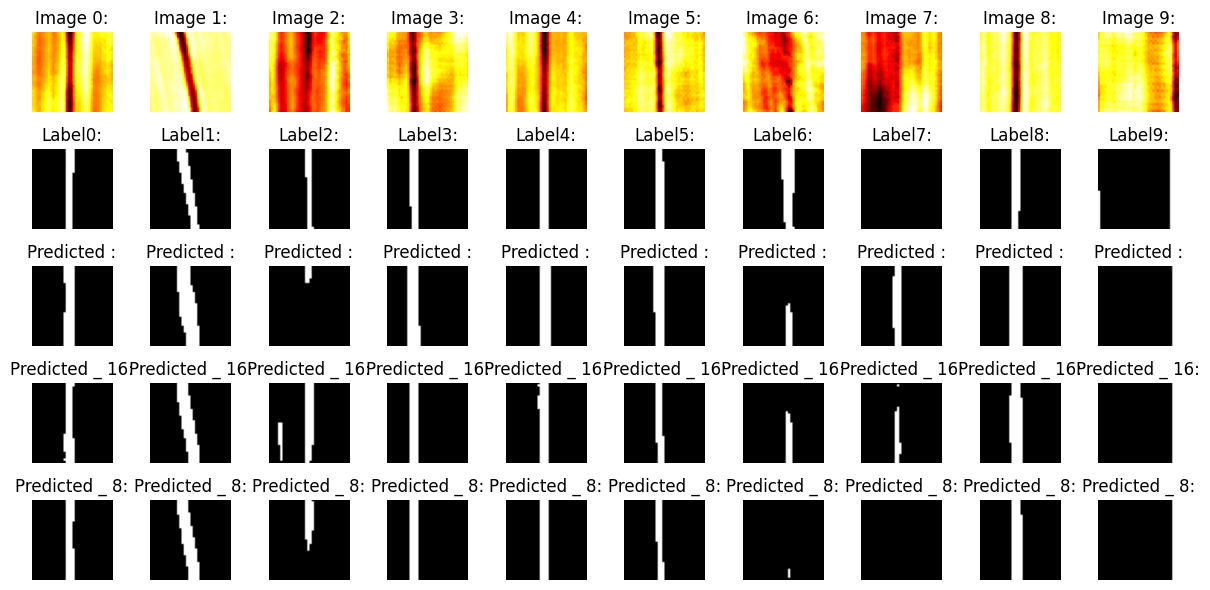

In [573]:
plt.figure(figsize=(12, 6))
for i in range(10):
    rand_index = np.random.randint(len(val_images))
    image = val_images[rand_index]
    label = val_labels[rand_index]
    predicted_mask = predict_image(model, image)
    predicted16 = predict_image(quant16_model, image)
    predicted8 = predict_image(quant8_model,image)
    plt.subplot(5, 10, i + 1)
    plt.imshow(image, cmap='hot')
    plt.title(f'Image {i}:')
    plt.axis('off')
    plt.subplot(5, 10, 10 + i + 1)
    plt.imshow(label, cmap='gray')
    plt.title(f'Label{i}:')
    plt.axis('off')
    plt.subplot(5,10,20+i+1)
    plt.imshow(predicted_mask, cmap = 'gray')
    plt.title('Predicted :')
    plt.axis('off')
    plt.subplot(5,10,30+i+1)
    plt.imshow(predicted16, cmap = 'gray')
    plt.title('Predicted _ 16:')
    plt.axis('off')
    plt.subplot(5,10,40+i+1)
    plt.imshow(predicted8, cmap = 'gray')
    plt.title('Predicted _ 8:')
    plt.axis('off')

plt.tight_layout()
plt.show()